In [22]:
from mhr.utils.utils import *
import numpy as np
from tqdm import tqdm

    
class BaseEvaluator(object):
    def __init__(self,args):
        self.statistic_files = args.statistic_files
        self.statistic_id_key = args.statistic_id_key
        self.statistic_object_keys = args.statistic_object_keys
        
        self.distribution_compose_list = args.distribution_compose_list
        self.distribution_reverse_index_files = args.distribution_reverse_index_files
        self.distribution_thresholds = args.distribution_thresholds

        self.head_tail_pass_key = args.head_tail_pass_key
        
        self.result_file_name = args.result_file_name
        self.result_question_id_key = args.result_question_id_key
        self.result_score_key = args.result_score_key
        self.result_files = args.result_files
        self.result_names = args.result_names
        
    def build_statistic_data(self):
        assert isinstance(self.statistic_files,list)
        if len(self.statistic_files) == 1:
            if self.statistic_files[0].endswith(".jsonl"):
                self.statistic_data = process_jsonl(self.statistic_files[0])
            elif self.statistic_files[0].endswith(".json"):
                self.statistic_data = load_json_file(self.statistic_files[0])
            if self.statistic_data[0].get("statistic",None) is not None:
                for item in self.statistic_data:
                    item["statistics"] = item["statistic"]
            elif self.statistic_data[0].get("statistics",None) is None:
                raise ValueError("The statistic data should contain 'statistics' or 'statistic' key")
        else:
            token_data = process_jsonl(self.statistic_files[0])
            object_data = process_jsonl(self.statistic_files[1])
            what_word_data = process_jsonl(self.statistic_files[2])
            
            object_dict = {item[self.statistic_id_key]:str2list(item[self.statistic_object_keys[1]]) for item in object_data}
            token_dict = {item[self.statistic_id_key]:str2list(item[self.statistic_object_keys[0]]) for item in token_data}
            what_word_dict = {item[self.statistic_id_key]:str2list(item[self.statistic_object_keys[2]]) for item in what_word_data}
            
            self.statistic_data = []
            ids = list(set(list(object_dict.keys()) + list(token_dict.keys()) + list(what_word_dict.keys())))
            for id in ids:
                objects = list(set(object_dict.get(id,[])))
                tokens = token_dict.get(id,[])
                what_words = what_word_dict.get(id,[])
                co_occurrences = []
                for i in range(len(objects)):
                    for j in range(i+1,len(objects)):
                        two_words = get_two_words(objects[i],objects[j])
                        co_occurrences.append(two_words)
                target_dict=dict(id=id,statistics=dict(object=objects,token=tokens,what_word=what_words,co_occurrence=co_occurrences))
                self.statistic_data.append(target_dict)
    
    def build_distribution_data(self):
        token_input_file,object_input_file,co_occurrence_input_file,what_word_input_file = self.distribution_reverse_index_files
        
        
        token_data = process_jsonl(token_input_file)
        object_data = process_jsonl(object_input_file)
        co_occurrence_data = process_jsonl(co_occurrence_input_file)
        what_word_data = process_jsonl(what_word_input_file)
        
        token_data.sort(key=lambda x: len(x["ids"]), reverse=True)
        object_data.sort(key=lambda x: len(x["ids"]), reverse=True)
        co_occurrence_data.sort(key=lambda x: len(x["ids"]), reverse=True)
        what_word_data.sort(key=lambda x: len(x["ids"]), reverse=True)
        
        token_data = [(x["object"],len(x["ids"])) for x in token_data]
        object_data = [(x["object"],len(x["ids"])) for x in object_data]
        co_occurrence_data = [(x["object"],len(x["ids"])) for x in co_occurrence_data]
        what_word_data = [(x["object"],len(x["ids"])) for x in what_word_data]
        
        self.token_data = token_data
        self.object_data = object_data
        self.co_occurrence_data = co_occurrence_data
        self.what_word_data = what_word_data

    def get_ratio_index(self):
        
        def get_90_index(data,sum,ratio=0.9):
            sum_90 = sum*ratio
            sum_temp = 0
            for i in range(len(data)):
                sum_temp += data[i][1]
                if sum_temp >= sum_90:
                    return i
                
        token_data,object_data,co_occurrence_data,what_word_data = self.token_data,self.object_data,self.co_occurrence_data,self.what_word_data
        token_sum = sum([x[1] for x in token_data])
        object_sum = sum([x[1] for x in object_data])
        co_occurrence_sum = sum([x[1] for x in co_occurrence_data])
        what_word_sum = sum([x[1] for x in what_word_data])
        
        token_threshold,object_threshold,co_occurrence_threshold,what_word_threshold = self.distribution_thresholds     
        token_90_loc = get_90_index(token_data,token_sum,token_threshold)
        object_90_loc = get_90_index(object_data,object_sum,object_threshold)
        co_occurrence_90_loc = get_90_index(co_occurrence_data,co_occurrence_sum,co_occurrence_threshold)
        what_word_90_loc = get_90_index(what_word_data,what_word_sum,what_word_threshold)
        print(f"token_{token_threshold}_loc:{token_90_loc}, object_{object_threshold}_loc:{object_90_loc}, co_occurrence_{co_occurrence_threshold}_loc:{co_occurrence_90_loc}, what_word_what_word_threshold_loc:{what_word_90_loc}")
        print(f"token_total {len(token_data)} object_total {len(object_data)} co_occurrence_total {len(co_occurrence_data)} what_word_total {len(what_word_data)}")
        
        
        self.token_dict = {x[0]:idx for idx,x in enumerate(token_data)}
        self.object_dict = {x[0]:idx for idx,x in enumerate(object_data)}
        self.co_occurrence_dict = {x[0]:idx for idx,x in enumerate(co_occurrence_data)}
        self.what_word_dict = {x[0]:idx for idx,x in enumerate(what_word_data)}
        self.loc_of_90=[token_90_loc,object_90_loc,co_occurrence_90_loc,what_word_90_loc]
    
    
    def get_head_tail_data_ids(self):
        def lookup_to_dict(obj,dictionary):
            return dictionary.get(obj,-1)

        def get_scores(data,dictionary,threshold):
            scores = []
            metadata = []
            for item in data:
                score = lookup_to_dict(item,dictionary)
                if score >= 0:
                    scores.append(score)
                    metadata.append({"object":item,"score":score})
            avg_score = sum(scores)/len(scores) if len(scores) > 0 else 0
            max_score = max(scores) if len(scores) > 0 else 0
            avg_pass = avg_score >= threshold
            least_pass = max_score >= threshold
            return scores,metadata,avg_pass,least_pass
        
        statistic_data = self.statistic_data
        token_90_loc,object_90_loc,co_occurrence_90_loc,what_word_90_loc = self.loc_of_90
        
        for item in statistic_data:
            tokens = item["statistics"]["token"]
            objects = item["statistics"]["object"]
            co_occurrences = item["statistics"]["co_occurrence"]
            what_words = item["statistics"]["what_word"]
            
            token_scores,token_metadata,token_avg_pass,token_least_pass = get_scores(tokens,self.token_dict,token_90_loc)
            object_scores,object_metadata,object_avg_pass,object_least_pass = get_scores(objects,self.object_dict,object_90_loc)
            co_occurrence_scores,co_occurrence_metadata,co_occurrence_avg_pass,co_occurrence_least_pass = get_scores(co_occurrences,self.co_occurrence_dict,co_occurrence_90_loc)
            what_word_scores,what_word_metadata,what_word_avg_pass,what_word_least_pass = get_scores(what_words,self.what_word_dict,what_word_90_loc)
            distribution_item = dict(token=dict(scores=token_scores,metadata=token_metadata,avg_pass=token_avg_pass,least_pass=token_least_pass),
                                    object=dict(scores=object_scores,metadata=object_metadata,avg_pass=object_avg_pass,least_pass=object_least_pass),
                                    co_occurrence=dict(scores=co_occurrence_scores,metadata=co_occurrence_metadata,avg_pass=co_occurrence_avg_pass,least_pass=co_occurrence_least_pass),
                                    what_word=dict(scores=what_word_scores,metadata=what_word_metadata,avg_pass=what_word_avg_pass,least_pass=what_word_least_pass))
            item["distribution"] = distribution_item
        
        token_pass_cnt = 0
        object_pass_cnt = 0
        co_occurrence_pass_cnt = 0
        what_word_pass_cnt = 0
        all_pass_cnt = 0
        pass_key = self.head_tail_pass_key
        pass_ids = []
        not_pass_ids = []
        for item in statistic_data:
            token_pass,object_pass,co_occurrence_pass,what_word_pass = 0,0,0,0
            if item["distribution"]["token"][pass_key]:
                token_pass = 1
                token_pass_cnt += 1
            if item["distribution"]["object"][pass_key]:
                object_pass = 1
                object_pass_cnt += 1
            if item["distribution"]["co_occurrence"][pass_key]:
                co_occurrence_pass_cnt += 1
                co_occurrence_pass = 1
            if item["distribution"]["what_word"][pass_key]:
                what_word_pass_cnt += 1
                what_word_pass = 1
            if token_pass + object_pass + co_occurrence_pass + what_word_pass >= 1:
                all_pass_cnt += 1
                pass_ids.append(item[self.statistic_id_key])
            else:
                not_pass_ids.append(item[self.statistic_id_key])
        self.pass_ids = pass_ids
        self.not_pass_ids = not_pass_ids
        self.tail_dict = {i:1 for i in pass_ids}
        self.head_dict = {i:1 for i in not_pass_ids}
        self.all_pass_cnt = all_pass_cnt
        print(f"token_pass_cnt:{token_pass_cnt}, object_pass_cnt:{object_pass_cnt}, \
      co_occurrence_pass_cnt:{co_occurrence_pass_cnt}, what_word_pass_cnt:{what_word_pass_cnt}, all_pass_cnt:{all_pass_cnt}")
        
        
    
    def build_eval_result_data(self):
        def get_item_by_multi_index(dictionary,keys):
            target = dictionary
            for key in keys:
                target = target[key]
            return target
        
        def get_res_from_lmms_eval(result_file):
            if os.path.isdir(result_file):
                result_file = os.path.join(result_file,self.result_file_name)
            else:
                result_file = result_file
            return load_json_file(result_file)["logs"]

        def get_result(result_data,head_dict,tail_dict):
            head_result = []
            tail_result = []
            for item in result_data:
                question_id = str(get_item_by_multi_index(item,self.result_question_id_key))
                if head_dict.get(question_id,-1) >= 0:
                    head_result.append(item)
                elif tail_dict.get(question_id,-1) >= 0:
                    tail_result.append(item)
            assert len(head_result) > 0
            assert len(tail_result) > 0
            head_scores = [get_item_by_multi_index(x,self.result_score_key) for x in head_result]
            tail_scores = [get_item_by_multi_index(x,self.result_score_key) for x in tail_result]
            head_acc = sum(head_scores)/len(head_scores)
            tail_acc = sum(tail_scores)/len(tail_scores)
            return head_acc,tail_acc

        result_data = []
        for i,result_file in enumerate(self.result_files):
            temp_result = get_res_from_lmms_eval(result_file)
            head_acc,tail_acc = get_result(temp_result,self.head_dict,self.tail_dict)
            result_data.append(dict(name=self.result_names[i],head_acc=head_acc,tail_acc=tail_acc))
        self.result_data = result_data
        return result_data
    
    def print_res(self):
        for item in self.result_data:
            print(f"Model:{item['name']} head_acc:{item['head_acc']} tail_acc:{item['tail_acc']}")
    
    def full_procedure(self):
        self.build_statistic_data()
        self.build_distribution_data()
        self.get_ratio_index()
        self.get_head_tail_data_ids()
        self.build_eval_result_data()
        self.print_res()
    
    def prepare_data_stage(self):
        self.build_statistic_data()
        self.build_distribution_data()
    
    
    def get_multiple_ratio_of_acc(self,begin,end,step):
        res = []
        
        temp_step = begin
        steps = []
        while temp_step +0.0001 < end:
            steps.append(temp_step)
            temp_step += step
        for ratio in tqdm(steps):
            self.distribution_thresholds=[ratio,ratio,ratio,ratio]
            self.get_ratio_index()
            self.get_head_tail_data_ids()
            self.build_eval_result_data()
            res.append(dict(ratio=ratio,result=self.result_data,all_pass_cnt=self.all_pass_cnt))
        return res
        

In [29]:
import yaml
import argparse
# with open('/mnt/petrelfs/songmingyang/code/mm/robustLMM/robustlmm/eval_res/eval_longtail/scripts/configs/llava_ft.yaml', 'r') as f:
#     parameters = yaml.safe_load(f)
sqa_config='/mnt/petrelfs/songmingyang/code/mm/robustLMM/robustlmm/eval_res/eval_longtail/scripts/configs/llava_ft.yaml'
vqav2_config="/mnt/petrelfs/songmingyang/code/mm/robustLMM/robustlmm/eval_res/eval_longtail/scripts/configs/vqav2_llava.yaml"
sqa_img_config="/mnt/petrelfs/songmingyang/code/mm/robustLMM/robustlmm/eval_res/eval_longtail/scripts/configs/sqa_img.yaml"
def load_yaml(file):
    with open(file, 'r') as f:
        return yaml.safe_load(f)
parameters = load_yaml(vqav2_config)

parameters["distribution_thresholds"] = [0.9]*4
args = argparse.Namespace(**parameters)
evaluator = BaseEvaluator(args)

    

In [30]:
evaluator.prepare_data_stage()

In [31]:
lt_results = evaluator.get_multiple_ratio_of_acc(0.5,1,0.1)

  0%|          | 0/5 [00:00<?, ?it/s]

token_0.5_loc:259, object_0.5_loc:79, co_occurrence_0.5_loc:7801, what_word_what_word_threshold_loc:2
token_total 512151 object_total 113149 co_occurrence_total 1065602 what_word_total 5770
token_pass_cnt:127100, object_pass_cnt:173181,       co_occurrence_pass_cnt:120482, what_word_pass_cnt:116718, all_pass_cnt:206891


 20%|██        | 1/5 [00:26<01:46, 26.57s/it]

token_0.6_loc:480, object_0.6_loc:132, co_occurrence_0.6_loc:18323, what_word_what_word_threshold_loc:5
token_total 512151 object_total 113149 co_occurrence_total 1065602 what_word_total 5770
token_pass_cnt:91187, object_pass_cnt:156492,       co_occurrence_pass_cnt:98043, what_word_pass_cnt:80462, all_pass_cnt:193300


 40%|████      | 2/5 [00:52<01:19, 26.47s/it]

token_0.7_loc:904, object_0.7_loc:239, co_occurrence_0.7_loc:46917, what_word_what_word_threshold_loc:8
token_total 512151 object_total 113149 co_occurrence_total 1065602 what_word_total 5770
token_pass_cnt:59008, object_pass_cnt:127854,       co_occurrence_pass_cnt:58688, what_word_pass_cnt:50023, all_pass_cnt:166361


 60%|██████    | 3/5 [01:18<00:52, 26.12s/it]

token_0.7999999999999999_loc:1908, object_0.7999999999999999_loc:545, co_occurrence_0.7999999999999999_loc:132863, what_word_what_word_threshold_loc:13
token_total 512151 object_total 113149 co_occurrence_total 1065602 what_word_total 5770
token_pass_cnt:31246, object_pass_cnt:79749,       co_occurrence_pass_cnt:16175, what_word_pass_cnt:30823, all_pass_cnt:117360


 80%|████████  | 4/5 [01:45<00:26, 26.31s/it]

token_0.8999999999999999_loc:6745, object_0.8999999999999999_loc:2222, co_occurrence_0.8999999999999999_loc:368641, what_word_what_word_threshold_loc:25
token_total 512151 object_total 113149 co_occurrence_total 1065602 what_word_total 5770
token_pass_cnt:9443, object_pass_cnt:25720,       co_occurrence_pass_cnt:1535, what_word_pass_cnt:15704, all_pass_cnt:47624


100%|██████████| 5/5 [02:11<00:00, 26.23s/it]


In [32]:
lt_results


[{'ratio': 0.5,
  'result': [{'name': 'baseline',
    'head_acc': 0.890821385501813,
    'tail_acc': 0.7615995862555682},
   {'name': 'balance',
    'head_acc': 0.8941578453704989,
    'tail_acc': 0.7639844169151886},
   {'name': 'aug',
    'head_acc': 0.8970119254991334,
    'tail_acc': 0.7643599769927163}],
  'all_pass_cnt': 206891},
 {'ratio': 0.6,
  'result': [{'name': 'baseline',
    'head_acc': 0.8748883822551383,
    'tail_acc': 0.7542493533368528},
   {'name': 'balance',
    'head_acc': 0.8780136791108432,
    'tail_acc': 0.7565902741852711},
   {'name': 'aug',
    'head_acc': 0.8790443621164471,
    'tail_acc': 0.7569901707191555}],
  'all_pass_cnt': 193300},
 {'ratio': 0.7,
  'result': [{'name': 'baseline',
    'head_acc': 0.821540641343529,
    'tail_acc': 0.7501042912703512},
   {'name': 'balance',
    'head_acc': 0.824782780822204,
    'tail_acc': 0.7522844897543697},
   {'name': 'aug',
    'head_acc': 0.8255683120455062,
    'tail_acc': 0.7526529655389599}],
  'all_pass_c

In [33]:
lt_results_bak = lt_results
len(evaluator.statistic_data)

214354

/tmp/ipykernel_164068/1168075821.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  star = patches.RegularPolygon(


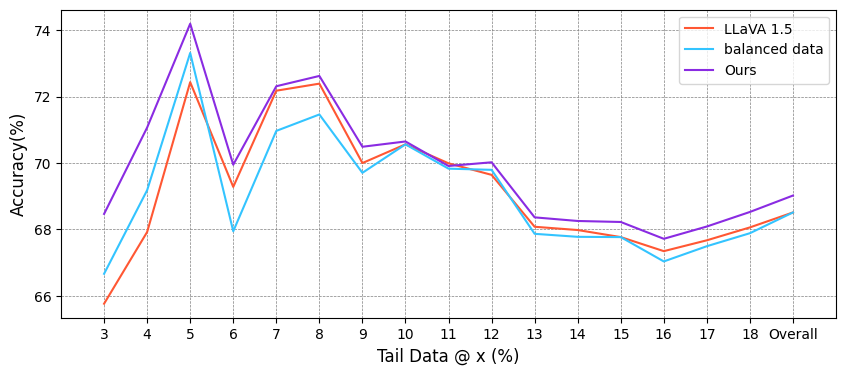

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as patches


lt_results = lt_results_bak[:-3]
# baseline_overall=76.6
# balanced_overall=76.9
# aug_overall=77.0

baseline_data = [item["result"][0]["tail_acc"]*100 for item in lt_results]
balanced_data = [item["result"][1]["tail_acc"]*100 for item in lt_results]
aug_data = [item["result"][2]["tail_acc"]*100 for item in lt_results] 
ratio_data = [(1-item["ratio"])*100 for item in lt_results] 

# 生成示例数据
x = ratio_data
y1 = baseline_data
y2 = balanced_data
y3 = aug_data

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(10, 4))  # 细长的图形尺寸

# 绘制折线图 
ax.plot(x, y1, label='LLaVA 1.5', color='#FF5733')  # 选择一种明亮的橘色
ax.plot(x, y2, label='balanced data', color='#33C4FF')  # 选择一种明亮的蓝色
ax.plot(x, y3, label='Ours', color='#8A2BE2')  # 选择一种明亮的绿色

# 设置标题和轴标签
# ax.set_title('Sine and Cosine Waves', fontsize=14, fontweight='bold')
ax.set_xlabel('Tail Data @ x (%)', fontsize=12)
ax.set_ylabel('Accuracy(%)', fontsize=12)
xtick_labels = [int(i) for i in x]  # 创建刻度标签，例如t0, t1, ..., t10
xtick_labels[0] = "Overall"
ax.set_xticks(x)  # 设置刻度位置
ax.set_xticklabels(xtick_labels)  # 设置刻度的标签
ax.set_xlim(left=np.min(x) - 1, right=np.max(x) + 1)
# 添加图例
ax.legend()
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
star = patches.RegularPolygon(
    (21, 77),     # 中心点坐标
    numVertices=5,  # 顶点数量
    radius=0.2,   # 半径
    orientation=np.pi / 2,  # 方向，π/2弧度使得一个顶点向上
    color='gold', edgecolor='black'
)

# 将五角星添加到图表中
ax.add_patch(star)
# 设置网格